In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import keras
#from cur import cur_decomposition
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.datasets import fashion_mnist  #
from keras.datasets import cifar10  #
from keras.models import Sequential, Model  # Model type to be used
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation, Conv1D, LocallyConnected1D, Reshape, Softmax, Input
from keras.utils import np_utils
import tensorflow as tf
import tensorflow.keras.backend as kb
from datetime import datetime
from tqdm.notebook import tqdm

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def ManifoldAngles(layerfeatlist,neighboursize1=10,classsize=10,dim_reduc_size=3,fileloc = "layers/"):

  starttime = tf.timestamp()
  tf.print("start: ")

  no_of_layers = len(layerfeatlist)
  reduction_quality = []
  class_chars = []

  for c1 in range(classsize):
    class_chars.append([])
    for layer_i in range(no_of_layers):
      class_chars[c1].append(LayerCharacteristics())
      layer_features = layerfeatlist[layer_i]

      layer_start = tf.timestamp()

      for i,x_i in enumerate(layer_features):

        class_chars[c1][layer_i].neighbour_dict[i] = tf.argsort(tf.norm( tf.math.subtract(layer_features,x_i) ,axis=1))[0:neighboursize1+1]# [1:neighboursize1+1]#templist

        W_i = tf.gather(layer_features,class_chars[c1][0].neighbour_dict[i])
        #class_chars[c1][layer_i].distances[i] = tf.math.reduce_euclidean_norm( tf.math.subtract( W_i , x_i ),axis=1)

        W_i = ( W_i - tf.math.reduce_mean(W_i,axis=0) )
        s, u, v = tf.linalg.svd( W_i )
        W_i_reduced = v[:,:dim_reduc_size]

        class_chars[c1][layer_i].svd_weights[i] = s[:dim_reduc_size]
        reduction_quality.append(  tf.reduce_sum( (s[:dim_reduc_size])/ tf.reduce_sum(s) ) )
        #tf.print("Reduction quality: ",  reduction_quality[-1])
        #if reduction_quality[-1] < 0.9: tf.print("Warning! Reduction quality: ",  reduction_quality[-1], i)
        class_chars[c1][layer_i].U_dict[i] = W_i_reduced

      tf.print("--layer time: ", tf.timestamp() - layer_start)
      class_chars[c1][layer_i].space_linearity_sum = 0.0
      angle_start = tf.timestamp()

      manifold_neighbour_angle_sum=[]
      for i in range(len(class_chars[c1][layer_i].U_dict)):
        manifold_neighbour_angle_sum_temp=[]
        manifold_neighbour_angle_sum.append([])

        for j in class_chars[c1][0].neighbour_dict[i]:
          if i != j:
            teta =  tf.matmul(  tf.transpose(class_chars[c1][layer_i].U_dict[i]),  class_chars[c1][layer_i].U_dict[int(j)]   )
            weights =  tf.matmul(  tf.transpose( tf.expand_dims(class_chars[c1][layer_i].svd_weights[i],0)), tf.expand_dims(class_chars[c1][layer_i].svd_weights[int(j)],0)  )
            Q = teta*weights
            #tf.print(i,"-----", j)
            #Q =  tf.matmul(  tf.transpose( tf.matmul( class_chars[c1][layer_i].U_dict[i], np.diag(class_chars[c1][layer_i].svd_weights[i]) ) ), tf.matmul( class_chars[c1][layer_i].U_dict[int(j)], np.diag(class_chars[c1][layer_i].svd_weights[int(j)]) ) )

            s, u, v = tf.linalg.svd( Q )

            tetaw = tf.reduce_sum(s)/tf.linalg.trace(weights)
            angles = tf.math.acos( tf.clip_by_value(tetaw,-1,1) )
            manifold_neighbour_angle_sum_temp.append( tf.math.sin(angles)  )

        #manifold_neighbour_angle_sum[i].append(tf.reduce_mean(tf.convert_to_tensor(manifold_neighbour_angle_sum_temp)) * tf.reduce_mean(class_chars[c1][layer_i].distances[i]) )
        manifold_neighbour_angle_sum[i].append(tf.reduce_mean(tf.convert_to_tensor(manifold_neighbour_angle_sum_temp)))
      #class_chars[c1][layer_i].space_linearity_sum = tf.reduce_sum( tf.convert_to_tensor(manifold_neighbour_angle_sum )) / tf.reduce_sum([tf.reduce_mean( x ) for x in list(class_chars[c1][layer_i].distances.values())])
      class_chars[c1][layer_i].space_linearity_sum = tf.reduce_mean( tf.convert_to_tensor(manifold_neighbour_angle_sum ))
      tf.print("--angle time: ", tf.timestamp() - angle_start)

  #tf.print("endtime: ", tf.timestamp() - starttime)
  if no_of_layers==1: tf.print("Average reduction quality: ",  tf.reduce_mean(reduction_quality))
  tf.print("endtime: ", tf.timestamp() - starttime)
  return class_chars,manifold_neighbour_angle_sum

#mnist

In [ ]:
(X_train, train_y), (X_test, test_y) = mnist.load_data()
X_train = X_train / 255
X_test = X_test/ 255

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
indicies = np.random.choice(X_train[train_y==0].shape[0],10,replace=True)
s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indicies]))
print( np.cumsum(s**2)/np.sum(s**2) )
print( np.sum(np.cumsum(s**2)/np.sum(s**2)<0.99) )

[0.65544134 0.7439754  0.81628716 0.86821735 0.9036088  0.93102896
 0.9504346  0.96924615 0.9867738  0.9999999 ]
9


In [ ]:
indicies = np.random.choice(X_train[train_y==0].shape[0],50,replace=True)
s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indicies]))
print( np.cumsum(s**2)/np.sum(s**2) )
print( np.sum(np.cumsum(s**2)/np.sum(s**2)<0.99) )

[0.65031075 0.71140903 0.76768225 0.79975957 0.8225275  0.83984274
 0.85464853 0.8683037  0.8799023  0.8909091  0.9006385  0.90832484
 0.91528356 0.9219448  0.92760736 0.9328902  0.9378322  0.9427066
 0.9469822  0.9507884  0.9544033  0.9577942  0.96093285 0.96379733
 0.9665411  0.9690749  0.9715051  0.9736824  0.9757733  0.9777477
 0.97968024 0.98151904 0.98329914 0.9848866  0.9863733  0.987823
 0.9891962  0.9904198  0.9915984  0.99274564 0.9938435  0.994882
 0.995853   0.9967429  0.99753606 0.9982491  0.9988975  0.99947727
 1.0000001  1.0000001 ]
37


In [ ]:
indicies = np.random.choice(X_train[train_y==0].shape[0],500,replace=True)
s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indicies]))
#print( np.cumsum(s**2)/np.sum(s**2) )
print( np.sum(np.cumsum(s**2)/np.sum(s**2)<0.99) )

137


In [ ]:
indicies = np.random.choice(X_train[train_y==0].shape[0],5000,replace=True)
s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indicies]))
#print( np.cumsum(s**2)/np.sum(s**2) )
print( np.sum(np.cumsum(s**2)/np.sum(s**2)<0.99) )

181


In [ ]:
indicies = np.random.choice(X_train[train_y==0].shape[0],10000,replace=True)
s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indicies]))
#print( np.cumsum(s**2)/np.sum(s**2) )
print( np.sum(np.cumsum(s**2)/np.sum(s**2)<0.99) )

184


In [ ]:
Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

In [ ]:
class LayerCharacteristics():
    def __init__(self):
      self.space_linearity_sum = []
      self.total_sum = []
      self.svd_weights = {}
      self.distances = {}
      self.neighbour_dict = {}
      self.U_dict = {}

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='PReLU',use_bias=False, kernel_initializer='random_uniform',padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2)))#model.add(tf.keras.layers.BatchNormalization())
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='softmax', kernel_initializer= 'random_uniform'))
  #model.add(Dense(10,activation='softmax'))

  return model

In [ ]:
nt = create_model()
nt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 1, 50)          39250     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history  = nt.fit(X_train, Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=1, batch_size = 128  ) #, callbacks=[callback]
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")


Epoch 1/20
469/469 [==============================] - 20s 11ms/step - loss: 0.5566 - categorical_accuracy: 0.8604 - val_loss: 0.2701 - val_categorical_accuracy: 0.9213
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.2382 - categorical_accuracy: 0.9326 - val_loss: 0.1959 - val_categorical_accuracy: 0.9441
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1815 - categorical_accuracy: 0.9482 - val_loss: 0.1631 - val_categorical_accuracy: 0.9515
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1486 - categorical_accuracy: 0.9565 - val_loss: 0.1426 - val_categorical_accuracy: 0.9602
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1249 - categorical_accuracy: 0.9641 - val_loss: 0.1285 - val_categorical_accuracy: 0.9639
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1073 - categorical_accuracy: 0.9690 - val_loss: 0.1163 - val_categorical_accuracy: 0.9675
Ep

In [ ]:
@tf.function
def get_hessian1(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
    loss = lossfunc(model(input),target)
    return tf.hessians(loss, input)

In [ ]:
@tf.function
def get_hessian2(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
    with tf.GradientTape() as t2:
      t2.watch(input)
      with tf.GradientTape() as t1:
        t1.watch(input)
        loss = lossfunc(model(input),target)
      g=t1.gradient(loss,input)
    return t2.jacobian(g,input)

In [ ]:
Heslist = []
lossfunc = tf.keras.losses.CategoricalCrossentropy()
for i in tqdm(range(X_train.shape[0])):
   Heslist.append(np.linalg.norm(get_hessian2(nt,X_train[i:i+1],Y_train[i:i+1],lossfunc=lossfunc)[0]))


  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
Heslist = np.array(Heslist)

In [ ]:
Heslist[train_y==0].shape

(5923,)

In [ ]:
Heslist[np.argsort(Heslist)][-datasize:]

array([7.13558951e-13, 2.80359714e-12, 3.23582427e-11, ...,
       1.22209188e+03, 1.25866437e+03, 1.29470945e+03])

In [ ]:
np.argsort(classcurvatures[0][:,0])[-datasize:]

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9892200231552124 val acc = 0.9732999801635742
  train acc = 0.9903799891471863 val acc = 0.972100019454956
  train acc = 0.9908400177955627 val acc = 0.9714999794960022
  train acc = 0.9908999800682068 val acc = 0.9718999862670898
  train acc = 0.9898200035095215 val acc = 0.9714000225067139
(34760, 28, 28)
  train acc = 0.9826812148094177 val acc = 0.9708999991416931
  train acc = 0.981041431427002 val acc = 0.972000002861023
  train acc = 0.9822784662246704 val acc = 0.9728000164031982
  train acc = 0.9815592765808105 val acc = 0.9724000096321106
  train acc = 0.9817318916320801 val acc = 0.9729999899864197
(24160, 28, 28)
  train acc = 0.9651076197624207 val acc = 0.9715999960899353
  train acc = 0.9639073014259338 val acc = 0.9678000211715698
  train acc = 0.9662665724754333 val acc = 0.9722999930381775
  train acc = 0.9661009907722473 val acc = 0.9732000231742859
  train acc = 0.9598096013069153 val acc = 0.9700000286102295
(16800, 28, 28)
  train a

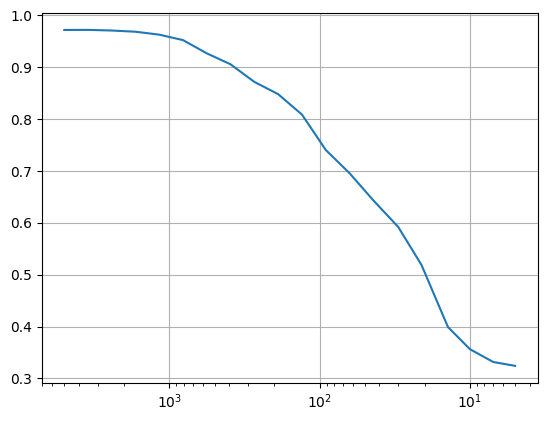

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist = []
valacclist= []
for datasize in tqdm(datasizes):
  indicies = np.argsort(Heslist[train_y==0])[-datasize:]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.argsort(Heslist[train_y==c])[-datasize:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  valacclist.append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    #acclist.append(history.history['categorical_accuracy'][-1])
    valacclist[-1].append(history.history['val_categorical_accuracy'][-1])

#plt.plot(datasizes,acclist)
plt.plot(datasizes,np.mean(valacclist,axis=1))
#plt.legend(['acc ','valacc'],loc='upper right',fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9967600107192993 val acc = 0.9670000076293945
  train acc = 0.9973000288009644 val acc = 0.9697999954223633
  train acc = 0.9966800212860107 val acc = 0.9664999842643738
  train acc = 0.9971399903297424 val acc = 0.970300018787384
  train acc = 0.996720016002655 val acc = 0.9671000242233276
(34760, 28, 28)
  train acc = 0.9941599369049072 val acc = 0.9652000069618225
  train acc = 0.9942175149917603 val acc = 0.9649999737739563
  train acc = 0.9955983757972717 val acc = 0.9668999910354614
  train acc = 0.994447648525238 val acc = 0.9625999927520752
  train acc = 0.9940736293792725 val acc = 0.963100016117096
(24160, 28, 28)
  train acc = 0.9886175394058228 val acc = 0.9592000246047974
  train acc = 0.9904801249504089 val acc = 0.9611999988555908
  train acc = 0.9900248050689697 val acc = 0.960099995136261
  train acc = 0.9893211722373962 val acc = 0.9602000117301941
  train acc = 0.9886175394058228 val acc = 0.9603000283241272
(16800, 28, 28)
  train acc

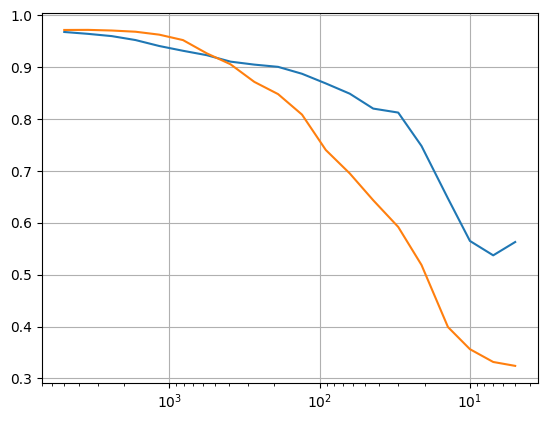

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist = []
valacclistrand= []
for datasize in tqdm(datasizes):
  indicies = np.random.choice(X_train[train_y==0].shape[0],datasize,replace=True)
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.random.choice(Y_train[train_y==c].shape[0],datasize,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  valacclistrand.append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    #acclist.append(history.history['categorical_accuracy'][-1])
    valacclistrand[-1].append(history.history['val_categorical_accuracy'][-1])

#plt.plot(datasizes,acclist)
plt.plot(datasizes,np.mean(valacclistrand,axis=1))
plt.plot(datasizes,np.mean(valacclist,axis=1))
#plt.legend(['acc ','valacc'],loc='upper right',fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()


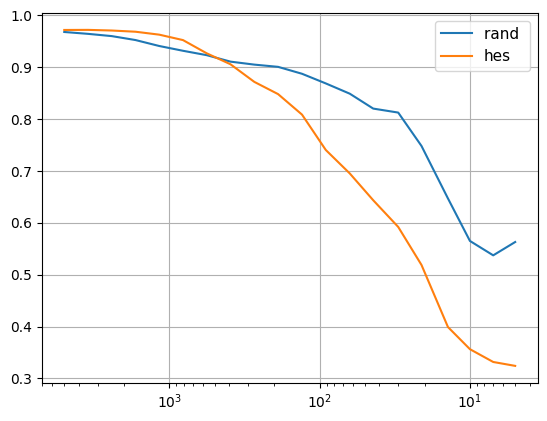

In [ ]:
plt.plot(datasizes,np.mean(valacclistrand,axis=1))
plt.plot(datasizes,np.mean(valacclist,axis=1))
plt.legend(['rand ','hes'],loc='upper right',fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

-------------------------------

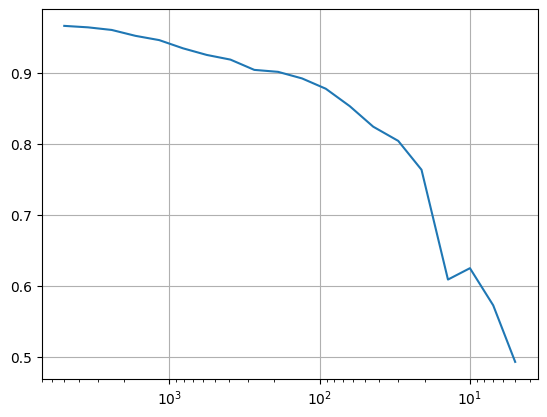

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist = []
valacclist= []
for datasize in tqdm(datasizes):
  indicies = np.random.choice(X_train[train_y==0].shape[0],datasize,replace=True)
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.random.choice(Y_train[train_y==c].shape[0],datasize,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  valacclist.append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    #acclist.append(history.history['categorical_accuracy'][-1])
    valacclist[-1].append(history.history['val_categorical_accuracy'][-1])

#plt.plot(datasizes,acclist)
plt.plot(datasizes,np.mean(valacclist,axis=1))
#plt.legend(['acc ','valacc'],loc='upper right',fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()


In [ ]:
import torch

def matr_to_origin(tens, indx):
  [dim1, dim2] = tens.shape
  t = tens[:, indx]
  t = t.resize(dim1, 1).expand(dim1, dim2)
  return tens-t

def matr_zero_mean(M):
  [dim1, dim2] = M.shape
  mn = torch.mean(M, 1)
  mn = mn.resize(dim1, 1).expand(dim1, dim2)
  return M-mn

def calc_mi(m, ind,rdim, nnum):
  mto = matr_to_origin(m, ind)
  dig = torch.diag(torch.matmul(torch.transpose(mto, 0, 1), mto))
  salad, ind = torch.sort(dig)
  ind_e = ind[1:nnum+1]
  mi= matr_zero_mean(m[:, ind_e])
  u, s, vh = torch.linalg.svd(mi, full_matrices=True)
  return( torch.matmul(u[:,:rdim], torch.diag(s[:rdim])), s[:rdim], ind_e)

def curv_calc(m, rdim, nnum):
  try:
    if m.shape[1]<=rdim:
      print("error")
      return 1.25
  except:
    print("error")
    return 1.25
  ang_l = []
  ne_dict = dict()
  for i in range(m.shape[1]):
    try:
      [usi, si, inds] = ne_dict[i]
    except:
      usi, si, inds = calc_mi(m, i, rdim, nnum)
      ne_dict[i] = [usi, si, inds]
    theta = 0
    for j in range(inds.shape[0]):
      try:
        [usj, sj, indsj] = ne_dict[inds[j].item()]
      except:
        usj, sj, indsj = calc_mi(m, inds[j].item(), rdim, nnum)
        ne_dict[inds[j].item()] = [usj, sj, indsj]
      Q = torch.matmul(torch.transpose(usi, 0, 1), usj)
      uq, sq, vq = torch.linalg.svd(Q)
      theta_ij = torch.sin(torch.acos(torch.clamp(torch.sum(sq)/torch.sum(si*sj), min=-1.0, max=1.0)))
      theta = theta + theta_ij.item()
    ang_l.append(theta/nnum)
  return(ang_l, ne_dict)

In [ ]:
layerfeatlist[0][0]

array([-8.772133  , -1.8045967 , -0.98661864, -2.1336796 , -0.22976397,
       -0.30429807, -0.8600081 , -0.3093467 , -2.0929706 , -0.444357  ,
       -0.3392857 , -0.21905905,  0.5945264 ,  0.4346436 ,  0.72430056,
       -1.1210518 ,  0.15525146, -0.9431747 ,  0.8064276 ,  0.15139742,
        0.4452992 , -0.25576302, -0.8704767 , -0.02834488, -0.19277784,
       -0.04511853, -1.1046737 , -0.03371475, -0.40468675, -0.14360075,
       -0.09705024, -0.1664188 , -0.0712649 , -0.4755801 , -0.3045394 ,
       -0.10670339, -0.21204211, -0.51086843, -0.1980987 , -0.14242153,
       -0.289943  , -0.09774227, -0.2671849 , -0.03894432, -0.25851655,
       -0.24611849, -0.8228962 , -0.41123375, -0.0884097 , -0.24668066],
      dtype=float32)

tensor([[-8.7721, -1.8046, -0.9866,  ..., -0.4112, -0.0884, -0.2467],
        [-9.3309, -1.3279, -1.9750,  ..., -0.2566,  0.1505,  0.6312],
        [-8.2100, -4.8707,  2.5490,  ..., -0.1046, -0.3957, -0.3798],
        ...,
        [-6.6672, -3.6677, -3.0395,  ...,  0.2008,  0.3160, -0.4301],
        [-7.9806, -4.7304, -3.0288,  ..., -0.4204,  0.2538,  0.2461],
        [-7.7887, -3.4519, -4.5334,  ..., -0.2789, -0.4913,  0.1787]])

In [ ]:
ang_l_

array([[0.8318494 ],
       [0.8187604 ],
       [0.70636606],
       ...,
       [0.6895441 ],
       [0.76185477],
       [0.7880398 ]], dtype=float32)

In [ ]:
classcurvatures = []
for c in tqdm(range(10)):

  lowersize = 50
  s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==c]))
  layerdata = (u[:,:lowersize]*s[:lowersize]).numpy()
  tf.print('layer quality: ', tf.norm(s[:lowersize]) / tf.norm(s))
  del s,u,v

  layerfeatlist = [layerdata]
  results,manifold_neighbour_angle_sum =  ManifoldAngles(layerfeatlist, classsize= 1,neighboursize1=10 ,dim_reduc_size=5,fileloc = "None")
  #ans = curv_calc(torch.tensor(layerfeatlist[0]),5,10)
  #ang_l_ = ans[0]
  #ne_dic_ = ans[1]
  classcurvatures.append(np.array(manifold_neighbour_angle_sum))

  0%|          | 0/10 [00:00<?, ?it/s]

layer quality:  0.974430561
start: 
--layer time:  39.744450092315674
--angle time:  213.26103687286377
Average reduction quality:  0.694660246
endtime:  253.04516315460205
layer quality:  0.983819127
start: 
--layer time:  42.061491966247559
--angle time:  239.47190499305725
Average reduction quality:  0.733106196
endtime:  281.57155299186707
layer quality:  0.958277524
start: 
--layer time:  38.579964876174927
--angle time:  212.62933087348938
Average reduction quality:  0.68175447
endtime:  251.24305009841919
layer quality:  0.961578906
start: 
--layer time:  39.941026926040649
--angle time:  218.43872904777527
Average reduction quality:  0.676717043
endtime:  258.41464996337891
layer quality:  0.96185708
start: 
--layer time:  37.375962972640991
--angle time:  207.71004104614258
Average reduction quality:  0.688986421
endtime:  245.12382817268372
layer quality:  0.957259119
start: 
--layer time:  35.614689111709595
--angle time:  192.90683197975159
Average reduction quality:  0.677

In [ ]:
indicies = np.argsort(classcurvatures[0][:,0])[:datasize]

In [ ]:
classcurvatures[0][:,0][indicies]

array([0.27189788, 0.2718979 , 0.27189797, 0.27189803, 0.36605802],
      dtype=float32)

In [ ]:
indicies

array([4652, 1433, 3401, 2230, 1814])

In [ ]:
np.argsort(classcurvatures[0][:,0])

array([4378, 4370,  939, ..., 3401, 2230, 1814])

In [ ]:
classcurvatures[0][:,0]

array([0.8731988 , 0.8512875 , 0.7249561 , ..., 0.68539107, 0.79772663,
       0.6660352 ], dtype=float32)

In [ ]:
classcurvatures[0][:,0][indicies]

array([0.9317827 , 0.9325166 , 0.9346182 , 0.93599784, 0.94053066],
      dtype=float32)

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9918400049209595 val acc = 0.968999981880188
(34760, 28, 28)
  train acc = 0.9874568581581116 val acc = 0.9646999835968018
(24160, 28, 28)
  train acc = 0.9816638827323914 val acc = 0.9610000252723694
(16800, 28, 28)
  train acc = 0.9747023582458496 val acc = 0.9491999745368958
(11670, 28, 28)
  train acc = 0.9602399468421936 val acc = 0.9330999851226807
(8110, 28, 28)
  train acc = 0.9512947201728821 val acc = 0.923799991607666
(5640, 28, 28)
  train acc = 0.9372340440750122 val acc = 0.9088000059127808
(3920, 28, 28)
  train acc = 0.9288265109062195 val acc = 0.8873999714851379
(2720, 28, 28)
  train acc = 0.9257352948188782 val acc = 0.873199999332428
(1890, 28, 28)
  train acc = 0.9158729910850525 val acc = 0.8622999787330627
(1310, 28, 28)
  train acc = 0.9045801758766174 val acc = 0.8440999984741211
(910, 28, 28)
  train acc = 0.8791208863258362 val acc = 0.8303999900817871
(630, 28, 28)
  train acc = 0.858730137348175 val acc = 0.7962999939918518


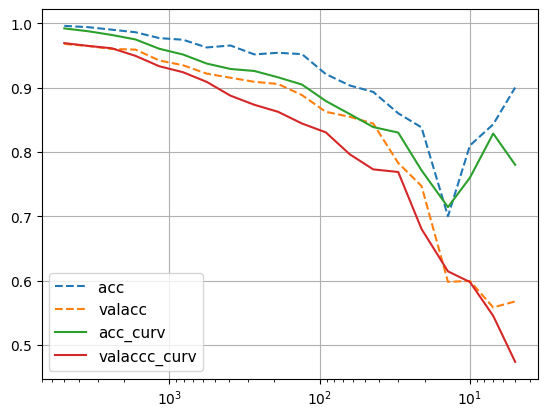

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist_curv = []
valacclist_curv= []
for datasize in tqdm(datasizes):
  indicies = np.argsort(classcurvatures[0][:,0])[-datasize:]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.argsort(classcurvatures[c][:,0])[-datasize:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist.append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    #acclist_curv.append(history.history['categorical_accuracy'][-1])
    valacclist_curv[-1].append(history.history['val_categorical_accuracy'][-1])

#plt.plot(datasizes,acclist,'--')
plt.plot(datasizes,valacclist,'--')
#plt.plot(datasizes,acclist_curv)
plt.plot(datasizes,valacclist_curv)
#plt.legend(['acc ','valacc','acc_curv','valaccc_curv'],fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9937000274658203 val acc = 0.970300018787384
(34760, 28, 28)
  train acc = 0.9935557842254639 val acc = 0.9656999707221985
(24160, 28, 28)
  train acc = 0.9912665486335754 val acc = 0.9585999846458435
(16800, 28, 28)
  train acc = 0.990059494972229 val acc = 0.9509999752044678
(11670, 28, 28)
  train acc = 0.9863753318786621 val acc = 0.9444000124931335
(8110, 28, 28)
  train acc = 0.9792848229408264 val acc = 0.9323999881744385
(5640, 28, 28)
  train acc = 0.9684396982192993 val acc = 0.9247000217437744
(3920, 28, 28)
  train acc = 0.9604591727256775 val acc = 0.9103000164031982
(2720, 28, 28)
  train acc = 0.9404411911964417 val acc = 0.8934999704360962
(1890, 28, 28)
  train acc = 0.9359788298606873 val acc = 0.8830000162124634
(1310, 28, 28)
  train acc = 0.9221373796463013 val acc = 0.864799976348877
(910, 28, 28)
  train acc = 0.8725274801254272 val acc = 0.8396000266075134
(630, 28, 28)
  train acc = 0.8761904835700989 val acc = 0.8147000074386597

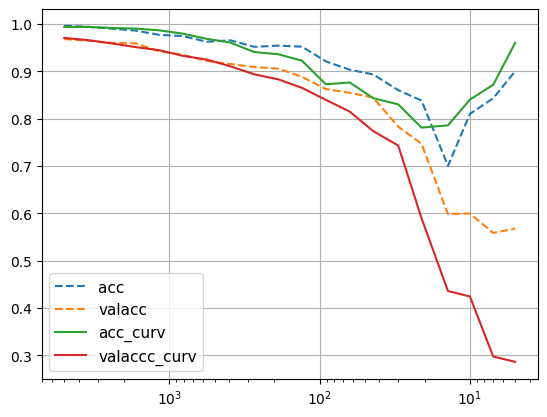

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist_curv = []
valacclist_curv= []
for datasize in tqdm(datasizes):
  indicies  = np.argsort(classcurvatures[0][:,0])[:datasize]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = indicies = np.argsort(classcurvatures[c][:,0])[:datasize]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  nt = create_model()
  #nt.summary()
  #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
  nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
  history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
  print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
  acclist_curv.append(history.history['categorical_accuracy'][-1])
  valacclist_curv.append(history.history['val_categorical_accuracy'][-1])

plt.plot(datasizes,acclist,'--')
plt.plot(datasizes,valacclist,'--')
plt.plot(datasizes,acclist_curv)
plt.plot(datasizes,valacclist_curv)
plt.legend(['acc ','valacc','acc_curv','valaccc_curv'],fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:
datasize1

array([2500, 1738, 1208,  840,  583,  405,  282,  196,  136,   94,   65,
         45,   31,   22,   15,   10,    7,    5,    3,    2])

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9915800094604492 val acc = 0.9728999733924866
(34760, 28, 28)
  train acc = 0.9893268346786499 val acc = 0.967199981212616
(24160, 28, 28)
  train acc = 0.9863410592079163 val acc = 0.9660000205039978
(16800, 28, 28)
  train acc = 0.9760119318962097 val acc = 0.9587000012397766
(11670, 28, 28)
  train acc = 0.9666666388511658 val acc = 0.9480999708175659
(8110, 28, 28)
  train acc = 0.9540073871612549 val acc = 0.9362000226974487
(5640, 28, 28)
  train acc = 0.9400709271430969 val acc = 0.9258000254631042
(3920, 28, 28)
  train acc = 0.9244897961616516 val acc = 0.9172000288963318
(2720, 28, 28)
  train acc = 0.9172794222831726 val acc = 0.9077000021934509
(1890, 28, 28)
  train acc = 0.8973544836044312 val acc = 0.895799994468689
(1310, 28, 28)
  train acc = 0.8587786555290222 val acc = 0.8726999759674072
(910, 28, 28)
  train acc = 0.8406593203544617 val acc = 0.8478999733924866
(630, 28, 28)
  train acc = 0.8317460417747498 val acc = 0.825699985027313

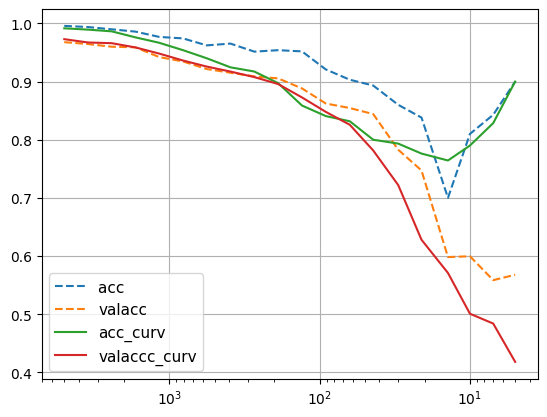

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist_curv = []
valacclist_curv= []
for datasize in tqdm(datasizes):
  datasize1 = (datasize//2).astype('int')
  datasize2 = (datasize - datasize1).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[:datasize1]
  indicies2  = np.argsort(classcurvatures[0][:,0])[-datasize2:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    indicies1  = np.argsort(classcurvatures[c][:,0])[:datasize1]
    indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  nt = create_model()
  #nt.summary()
  #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
  nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
  history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
  print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
  acclist_curv.append(history.history['categorical_accuracy'][-1])
  valacclist_curv.append(history.history['val_categorical_accuracy'][-1])

plt.plot(datasizes,acclist,'--')
plt.plot(datasizes,valacclist,'--')
plt.plot(datasizes,acclist_curv)
plt.plot(datasizes,valacclist_curv)
plt.legend(['acc ','valacc','acc_curv','valaccc_curv'],fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:
np.logspace(3.699,0.699,20).astype('int')

array([5000, 3476, 2416, 1680, 1167,  811,  564,  392,  272,  189,  131,
         91,   63,   44,   30,   21,   14,   10,    7,    5])

In [ ]:
datasizes = 5001-np.logspace(3.699,0.699,20).astype('int')
datasizes

array([   1, 1525, 2585, 3321, 3834, 4190, 4437, 4609, 4729, 4812, 4870,
       4910, 4938, 4957, 4971, 4980, 4987, 4991, 4994, 4996])

2961

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9940400123596191 val acc = 0.9702000021934509
(34760, 28, 28)
  train acc = 0.9934694766998291 val acc = 0.9681000113487244
(24160, 28, 28)
  train acc = 0.9910596013069153 val acc = 0.9625999927520752
(16800, 28, 28)
  train acc = 0.9864285588264465 val acc = 0.9553999900817871
(11670, 28, 28)
  train acc = 0.9820051193237305 val acc = 0.9431999921798706
(8110, 28, 28)
  train acc = 0.971023440361023 val acc = 0.934499979019165
(5640, 28, 28)
  train acc = 0.963652491569519 val acc = 0.9204000234603882
(3920, 28, 28)
  train acc = 0.9653061032295227 val acc = 0.916700005531311
(2720, 28, 28)
  train acc = 0.9573529362678528 val acc = 0.9110000133514404
(1890, 28, 28)
  train acc = 0.956084668636322 val acc = 0.9028000235557556
(1310, 28, 28)
  train acc = 0.9427480697631836 val acc = 0.890500009059906
(910, 28, 28)
  train acc = 0.9186813235282898 val acc = 0.8766000270843506
(630, 28, 28)
  train acc = 0.9095237851142883 val acc = 0.8607000112533569
(4

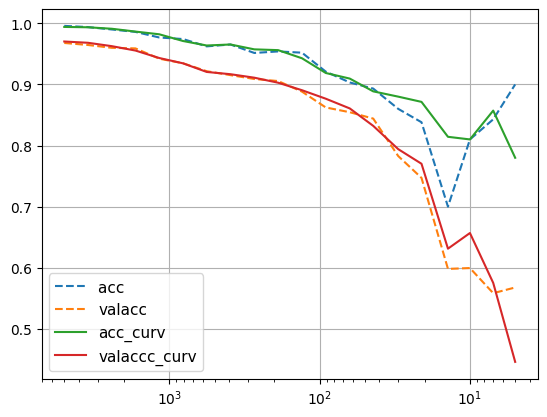

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist_curv = []
valacclist_curv= []
for datasize in tqdm(datasizes):
  datasize1 = (datasize//2).astype('int')
  datasize2 = (datasize - datasize1).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[classcurvatures[0][:,0].shape[0]//2 -datasize1 : classcurvatures[0][:,0].shape[0]//2 +datasize2]
  #indicies2  = np.argsort(classcurvatures[0][:,0])[:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    indicies1  = np.argsort(classcurvatures[c][:,0])[classcurvatures[c][:,0].shape[0]//2 -datasize1 : classcurvatures[c][:,0].shape[0]//2 +datasize2]
    #indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  nt = create_model()
  #nt.summary()
  #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
  nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
  history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
  print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
  acclist_curv.append(history.history['categorical_accuracy'][-1])
  valacclist_curv.append(history.history['val_categorical_accuracy'][-1])

plt.plot(datasizes,acclist,'--')
plt.plot(datasizes,valacclist,'--')
plt.plot(datasizes,acclist_curv)
plt.plot(datasizes,valacclist_curv)
plt.legend(['acc ','valacc','acc_curv','valaccc_curv'],fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:
namelist = []
namelist.append('Random selection')
namelist.append('Highest Curvatures')
namelist.append('Lowest Curvatures')
namelist.append('Highest+Lowest Curvatures')
namelist.append('Mid-Range Curvatures')

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9965999722480774 val acc = 0.9648000001907349
  train acc = 0.9963600039482117 val acc = 0.9710000157356262
  train acc = 0.9962199926376343 val acc = 0.9674999713897705
  train acc = 0.9970200061798096 val acc = 0.968999981880188
  train acc = 0.9954599738121033 val acc = 0.9643999934196472
(34760, 28, 28)
  train acc = 0.9944188594818115 val acc = 0.9649999737739563
  train acc = 0.9936133623123169 val acc = 0.9653000235557556
  train acc = 0.9943325519561768 val acc = 0.964900016784668
  train acc = 0.9935557842254639 val acc = 0.9631999731063843
  train acc = 0.992692768573761 val acc = 0.9624000191688538
(24160, 28, 28)
  train acc = 0.9878725409507751 val acc = 0.958299994468689
  train acc = 0.9903973340988159 val acc = 0.9599000215530396
  train acc = 0.9909768104553223 val acc = 0.9563999772071838
  train acc = 0.9888659119606018 val acc = 0.9567000269889832
  train acc = 0.9893211722373962 val acc = 0.9593999981880188
(16800, 28, 28)
  train ac

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9922800064086914 val acc = 0.9711999893188477
  train acc = 0.9922999739646912 val acc = 0.9733999967575073
  train acc = 0.9912400245666504 val acc = 0.9678999781608582
  train acc = 0.9916599988937378 val acc = 0.9678000211715698
  train acc = 0.9927800297737122 val acc = 0.9682000279426575
(34760, 28, 28)
  train acc = 0.9894994497299194 val acc = 0.9634000062942505
  train acc = 0.9866800904273987 val acc = 0.9605000019073486
  train acc = 0.9899885058403015 val acc = 0.9650999903678894
  train acc = 0.9885212779045105 val acc = 0.9625999927520752
  train acc = 0.9883774518966675 val acc = 0.965499997138977
(24160, 28, 28)
  train acc = 0.9820364117622375 val acc = 0.9538999795913696
  train acc = 0.9824503064155579 val acc = 0.9560999870300293
  train acc = 0.9833609461784363 val acc = 0.9567999839782715
  train acc = 0.9838162064552307 val acc = 0.9555000066757202
  train acc = 0.9842301607131958 val acc = 0.9560999870300293
(16800, 28, 28)
  train

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9960399866104126 val acc = 0.9692999720573425
  train acc = 0.9954400062561035 val acc = 0.9696000218391418
  train acc = 0.9950600266456604 val acc = 0.9686999917030334
  train acc = 0.9951800107955933 val acc = 0.9696000218391418
  train acc = 0.9957799911499023 val acc = 0.9678000211715698
(34760, 28, 28)
  train acc = 0.9953970313072205 val acc = 0.9628000259399414
  train acc = 0.9944188594818115 val acc = 0.9617000222206116
  train acc = 0.9954545497894287 val acc = 0.9603999853134155
  train acc = 0.9954257607460022 val acc = 0.9625999927520752
  train acc = 0.9941887259483337 val acc = 0.9628000259399414
(24160, 28, 28)
  train acc = 0.9918046593666077 val acc = 0.9531999826431274
  train acc = 0.9941639304161072 val acc = 0.9560999870300293
  train acc = 0.9933360815048218 val acc = 0.9569000005722046
  train acc = 0.9943294525146484 val acc = 0.9563000202178955
  train acc = 0.9929221868515015 val acc = 0.953499972820282
(16800, 28, 28)
  train

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.991599977016449 val acc = 0.9717000126838684
  train acc = 0.990559995174408 val acc = 0.9715999960899353
  train acc = 0.9908199906349182 val acc = 0.9722999930381775
  train acc = 0.9906799793243408 val acc = 0.9690999984741211
  train acc = 0.9907199740409851 val acc = 0.9717000126838684
(34760, 28, 28)
  train acc = 0.9882911443710327 val acc = 0.9692000150680542
  train acc = 0.9896432757377625 val acc = 0.9685999751091003
  train acc = 0.9865074753761292 val acc = 0.9668999910354614
  train acc = 0.9867088794708252 val acc = 0.9692000150680542
  train acc = 0.9864211678504944 val acc = 0.9692999720573425
(24160, 28, 28)
  train acc = 0.9814155697822571 val acc = 0.9648000001907349
  train acc = 0.9814569354057312 val acc = 0.9641000032424927
  train acc = 0.9819122552871704 val acc = 0.9649999737739563
  train acc = 0.9837334156036377 val acc = 0.965499997138977
  train acc = 0.9807119369506836 val acc = 0.9646000266075134
(16800, 28, 28)
  train a

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9943400025367737 val acc = 0.9696999788284302
  train acc = 0.9950199723243713 val acc = 0.9728000164031982
  train acc = 0.9943199753761292 val acc = 0.9682999849319458
  train acc = 0.9953600168228149 val acc = 0.9685999751091003
  train acc = 0.994700014591217 val acc = 0.9700999855995178
(34760, 28, 28)
  train acc = 0.9935270547866821 val acc = 0.9648000001907349
  train acc = 0.9932969212532043 val acc = 0.9614999890327454
  train acc = 0.9943613409996033 val acc = 0.9645000100135803
  train acc = 0.9947640895843506 val acc = 0.967199981212616
  train acc = 0.9935845732688904 val acc = 0.9643999934196472
(24160, 28, 28)
  train acc = 0.9913079738616943 val acc = 0.9584000110626221
  train acc = 0.9911423921585083 val acc = 0.957099974155426
  train acc = 0.9927566051483154 val acc = 0.9602000117301941
  train acc = 0.9920943975448608 val acc = 0.9585000276565552
  train acc = 0.9906870722770691 val acc = 0.9589999914169312
(16800, 28, 28)
  train a

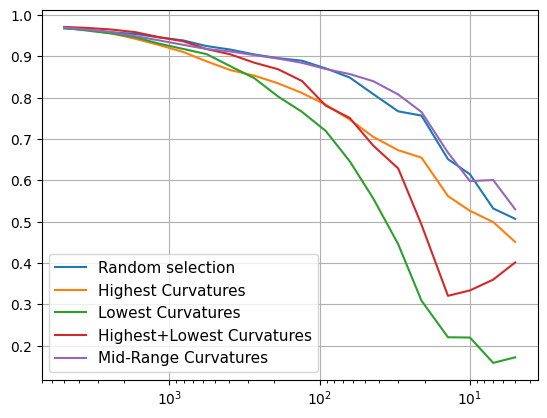

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
namelist = []
valacclist = [[]]
for datasize in tqdm(datasizes):
  indicies = np.random.choice(X_train[train_y==0].shape[0],datasize,replace=True)
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.random.choice(Y_train[train_y==c].shape[0],datasize,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Random selection')

valacclist.append([])
for datasize in tqdm(datasizes):
  indicies = np.argsort(classcurvatures[0][:,0])[-datasize:]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.argsort(classcurvatures[c][:,0])[-datasize:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Highest Curvatures')

valacclist.append([])
for datasize in tqdm(datasizes):
  indicies  = np.argsort(classcurvatures[0][:,0])[:datasize]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = indicies = np.argsort(classcurvatures[c][:,0])[:datasize]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Lowest Curvatures')

valacclist.append([])
for datasize in tqdm(datasizes):
  datasize1 = (datasize//2).astype('int')
  datasize2 = (datasize - datasize1).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[:datasize1]
  indicies2  = np.argsort(classcurvatures[0][:,0])[-datasize2:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    indicies1  = np.argsort(classcurvatures[c][:,0])[:datasize1]
    indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Highest+Lowest Curvatures')

valacclist.append([])
for datasize in tqdm(datasizes):
  datasize1 = (datasize//2).astype('int')
  datasize2 = (datasize - datasize1).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[classcurvatures[0][:,0].shape[0]//2 -datasize1 : classcurvatures[0][:,0].shape[0]//2 +datasize2]
  #indicies2  = np.argsort(classcurvatures[0][:,0])[:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    indicies1  = np.argsort(classcurvatures[c][:,0])[classcurvatures[c][:,0].shape[0]//2 -datasize1 : classcurvatures[c][:,0].shape[0]//2 +datasize2]
    #indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Mid-Range Curvatures')


#plt.plot(datasizes,acclist,'--')
#plt.plot(datasizes,valacclist,'--')
#plt.plot(datasizes,acclist_curv)
for curve in valacclist:
  plt.plot(datasizes,np.mean(curve,axis=1))
plt.legend(namelist,fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:
import pickle as pkl

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
namelist = []
valacclist = [[]]
for datasize in tqdm(datasizes):
  indicies = np.random.choice(X_train[train_y==0].shape[0],datasize,replace=True)
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.random.choice(Y_train[train_y==c].shape[0],datasize,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Random selection')

name = str(namelist[-1])  #'WideResNet-70-16'
fileObject = open('/content/drive/MyDrive/ValAcc/' + name, 'wb')
pkl.dump(valacclist, fileObject)
fileObject.close()

valacclist.append([])
for datasize in tqdm(datasizes):
  indicies = np.argsort(classcurvatures[0][:,0])[-datasize:]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.argsort(classcurvatures[c][:,0])[-datasize:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Highest Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'
fileObject = open('/content/drive/MyDrive/ValAcc/' + name, 'wb')
pkl.dump(valacclist, fileObject)
fileObject.close()

valacclist.append([])
for datasize in tqdm(datasizes):
  indicies  = np.argsort(classcurvatures[0][:,0])[:datasize]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = indicies = np.argsort(classcurvatures[c][:,0])[:datasize]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Lowest Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'
fileObject = open('/content/drive/MyDrive/ValAcc/' + name, 'wb')
pkl.dump(valacclist, fileObject)
fileObject.close()

valacclist.append([])
for datasize in tqdm(datasizes):
  datasize1 = (datasize//2).astype('int')
  datasize2 = (datasize - datasize1).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[:datasize1]
  indicies2  = np.argsort(classcurvatures[0][:,0])[-datasize2:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    indicies1  = np.argsort(classcurvatures[c][:,0])[:datasize1]
    indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Highest+Lowest Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'
fileObject = open('/content/drive/MyDrive/ValAcc/' + name, 'wb')
pkl.dump(valacclist, fileObject)
fileObject.close()

valacclist.append([])
for datasize in tqdm(datasizes):
  datasize1 = (datasize//2).astype('int')
  datasize2 = (datasize - datasize1).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[classcurvatures[0][:,0].shape[0]//2 -datasize1 : classcurvatures[0][:,0].shape[0]//2 +datasize2]
  #indicies2  = np.argsort(classcurvatures[0][:,0])[:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    indicies1  = np.argsort(classcurvatures[c][:,0])[classcurvatures[c][:,0].shape[0]//2 -datasize1 : classcurvatures[c][:,0].shape[0]//2 +datasize2]
    #indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Mid-Range Curvatures')

name = str(namelist[-1])  #'WideResNet-70-16'
fileObject = open('/content/drive/MyDrive/ValAcc/' + name, 'wb')
pkl.dump(valacclist, fileObject)
fileObject.close()

valacclist.append([])
for datasize in tqdm(datasizes):
  indicies = np.random.choice(X_train[train_y==0].shape[0],datasize,replace=True,p=classcurvatures[0][:,0]/np.sum(classcurvatures[0][:,0]) )
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.random.choice(Y_train[train_y==c].shape[0],datasize,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  valacclist[-1].append([])
  for i in range(5):
    nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    valacclist[-1][-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Semi-Random selection')

name = str(namelist[-1])  #'WideResNet-70-16'
fileObject = open('/content/drive/MyDrive/ValAcc/' + name, 'wb')
pkl.dump(valacclist, fileObject)
fileObject.close()

#plt.plot(datasizes,acclist,'--')
#plt.plot(datasizes,valacclist,'--')
#plt.plot(datasizes,acclist_curv)
plt.figure(figsize=(14, 10))
for curve in valacclist:
  plt.plot(datasizes,np.mean(curve,axis=1))
plt.legend(namelist,fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.9964799880981445 val acc = 0.9660999774932861
  train acc = 0.9970800280570984 val acc = 0.9682000279426575
  train acc = 0.9969000220298767 val acc = 0.9668999910354614
  train acc = 0.9972599744796753 val acc = 0.9668999910354614
  train acc = 0.9971399903297424 val acc = 0.9663000106811523
(34760, 28, 28)
  train acc = 0.9942175149917603 val acc = 0.9664000272750854
  train acc = 0.9936420917510986 val acc = 0.967199981212616
  train acc = 0.9933832287788391 val acc = 0.9674999713897705
  train acc = 0.9946489930152893 val acc = 0.967199981212616
  train acc = 0.9947065711021423 val acc = 0.9660999774932861
(24160, 28, 28)
  train acc = 0.9876241683959961 val acc = 0.9609000086784363
  train acc = 0.9896523356437683 val acc = 0.960099995136261
  train acc = 0.9896523356437683 val acc = 0.9575999975204468
  train acc = 0.9903559684753418 val acc = 0.9614999890327454
  train acc = 0.9887831211090088 val acc = 0.9599999785423279
(16800, 28, 28)
  train a

FileNotFoundError: ignored

In [ ]:
dt = datasizes[2]
print(dt)
space = np.linspace(0,classcurvatures[0][:,0].shape[0]-1,dt,endpoint=True).astype('int')
print(space)
indicies1  = np.argsort(classcurvatures[0][:,0])[space]
indicies1.shape

2416
[   0    2    4 ... 5917 5919 5922]


(2416,)

In [ ]:
valacclist.append([])
for datasize in tqdm(datasizes):
  space = np.linspace(0,classcurvatures[0][:,0].shape[0]-1,datasize,endpoint=True).astype('int')
  indicies1  = np.argsort(classcurvatures[0][:,0])[space]
  #indicies2  = np.argsort(classcurvatures[0][:,0])[:]
  Reduced_X_train = X_train[train_y==0][indicies1]
  Reduced_Y_train = Y_train[train_y==0][indicies1]
  #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==0][indicies2] ])
  #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==0][indicies2] ])
  for c in range(1,10):
    space = np.linspace(0,classcurvatures[c][:,0].shape[0]-1,datasize,endpoint=True).astype('int')
    indicies1  = np.argsort(classcurvatures[c][:,0])[space]
    #indicies2  = np.argsort(classcurvatures[c][:,0])[-datasize2:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies1] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies1] ])
    #Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies2] ])
    #Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies2] ])
  print(Reduced_X_train.shape)

  np.random.seed(1337)
  np.random.shuffle(Reduced_X_train)
  np.random.seed(1337)
  np.random.shuffle(Reduced_Y_train)

  nt = create_model()
  #nt.summary()
  #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
  nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
  history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
  print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
  valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
namelist.append('Equal Spacing')

  0%|          | 0/20 [00:00<?, ?it/s]

(50000, 28, 28)
  train acc = 0.990880012512207 val acc = 0.9685999751091003
(34760, 28, 28)
  train acc = 0.9914844632148743 val acc = 0.9699000120162964
(24160, 28, 28)
  train acc = 0.9874585866928101 val acc = 0.9617000222206116
(16800, 28, 28)
  train acc = 0.9838690757751465 val acc = 0.957099974155426
(11670, 28, 28)
  train acc = 0.9731791019439697 val acc = 0.9474999904632568
(8110, 28, 28)
  train acc = 0.9655980467796326 val acc = 0.9366999864578247
(5640, 28, 28)
  train acc = 0.9551418423652649 val acc = 0.9217000007629395
(3920, 28, 28)
  train acc = 0.9538265466690063 val acc = 0.9204999804496765
(2720, 28, 28)
  train acc = 0.9511029124259949 val acc = 0.90420001745224
(1890, 28, 28)
  train acc = 0.9460317492485046 val acc = 0.9003999829292297
(1310, 28, 28)
  train acc = 0.9458015561103821 val acc = 0.8921999931335449
(910, 28, 28)
  train acc = 0.9186813235282898 val acc = 0.878600001335144
(630, 28, 28)
  train acc = 0.9079365134239197 val acc = 0.8579000234603882
(

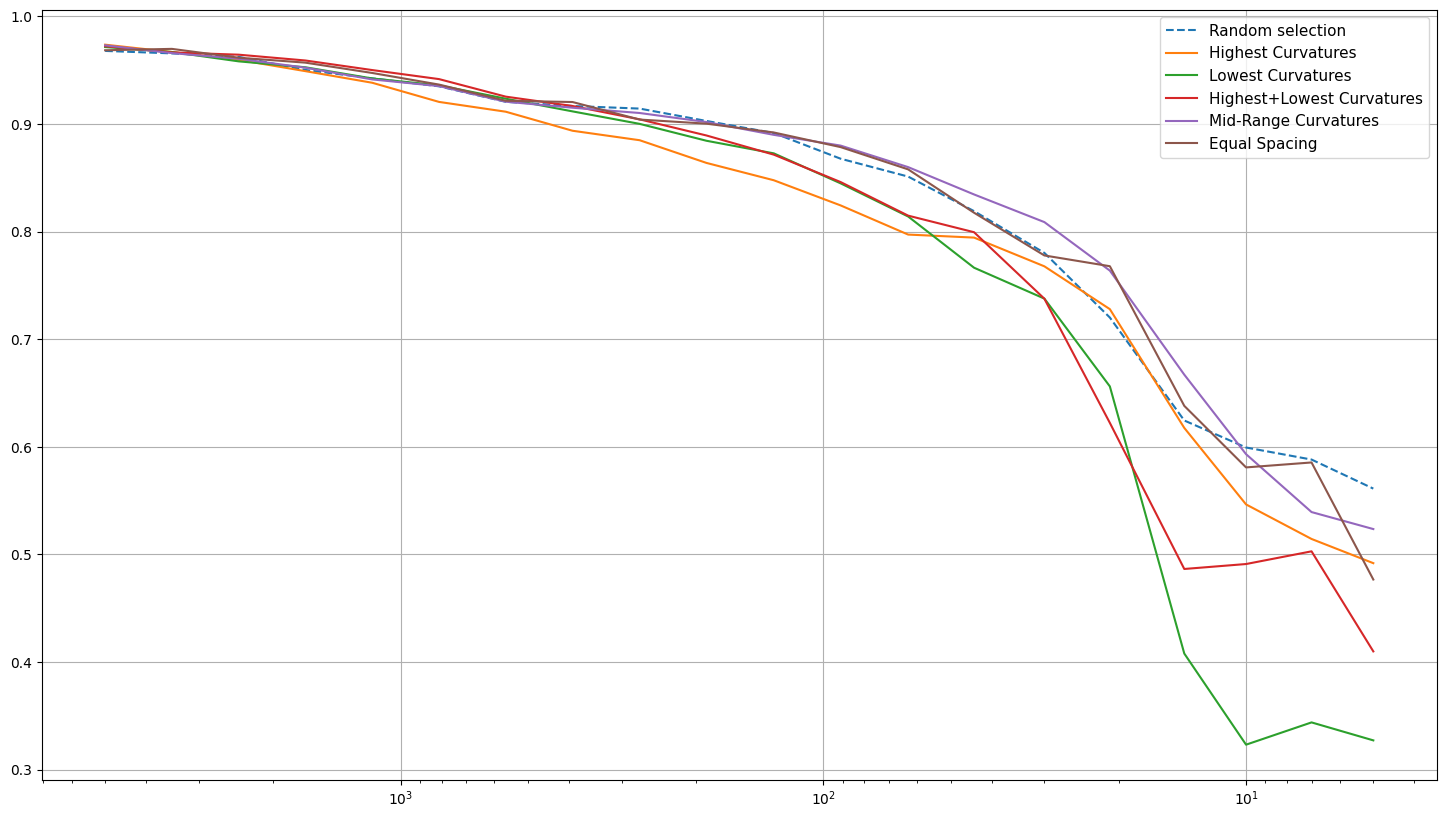

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(datasizes,valacclist[0],'--')
for curve in valacclist[1:]:
  plt.plot(datasizes,curve)
plt.legend(namelist,fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:

plt.plot(datasizes,acclist,'--')
plt.plot(datasizes,valacclist,'--')
plt.plot(datasizes,acclist_curv)
plt.plot(datasizes,valacclist_curv)
plt.legend(['acc ','valacc','acc_curv','valaccc_curv'],fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

In [ ]:
np.logspace(2,4.5,10)
np.random.choice(X_train.shape[0],10,replace=True)

array([ 9102, 47311, 56334, 46601,  2975, 51825,  6258, 55142, 52732,
       25558])

In [ ]:
for i in range()

#cifar

In [ ]:
(X_train, train_y), (X_test, test_y) = cifar10.load_data()
X_train = X_train / 255
X_test = X_test/ 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
def create_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='PReLU',use_bias=False, kernel_initializer='random_uniform',padding='valid'))
  #model.add(MaxPooling2D(pool_size=(2, 2)))#model.add(tf.keras.layers.BatchNormalization())
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='softmax', kernel_initializer= 'random_uniform'))
  #model.add(Dense(10,activation='softmax'))

  return model

In [ ]:
nt = create_model()
nt.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 1, 1, 50)          39250     
                                                                 
 flatten_5 (Flatten)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history  = nt.fit(X_train, Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=1, batch_size = 128  ) #, callbacks=[callback]
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")


Epoch 1/20
469/469 [==============================] - 5s 8ms/step - loss: 0.5518 - categorical_accuracy: 0.8656 - val_loss: 0.2800 - val_categorical_accuracy: 0.9212
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2548 - categorical_accuracy: 0.9269 - val_loss: 0.2126 - val_categorical_accuracy: 0.9385
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1948 - categorical_accuracy: 0.9446 - val_loss: 0.1688 - val_categorical_accuracy: 0.9522
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1565 - categorical_accuracy: 0.9548 - val_loss: 0.1474 - val_categorical_accuracy: 0.9586
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 0.1310 - categorical_accuracy: 0.9625 - val_loss: 0.1326 - val_categorical_accuracy: 0.9616
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.1122 - categorical_accuracy: 0.9673 - val_loss: 0.1196 - val_categorical_accuracy: 0.9650
Epoc

In [ ]:
datasizes = np.logspace(3.699,0.699,20).astype('int')
acclist = []
valacclist= []
for datasize in tqdm(datasizes):
  indicies = np.random.choice(X_train[train_y==0].shape[0],datasize,replace=True)
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.random.choice(Y_train[train_y==c].shape[0],datasize,replace=True)
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
  nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
  history  = nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
  print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
  acclist.append(history.history['categorical_accuracy'][-1])
  valacclist.append(history.history['val_categorical_accuracy'][-1])



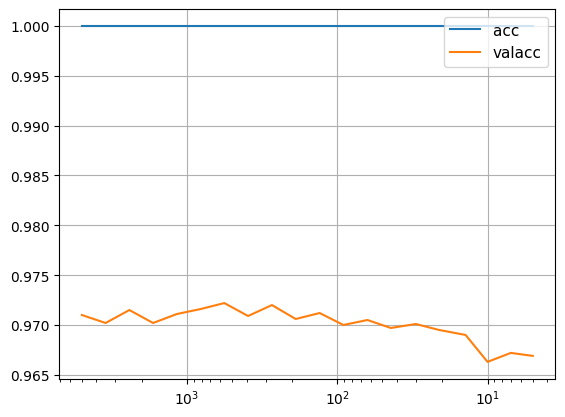

In [ ]:
plt.plot(datasizes,acclist)
plt.plot(datasizes,valacclist)
plt.legend(['acc ','valacc'],loc='upper right',fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()

#---------------